In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

from sklearn.cluster import KMeans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import metrics

In [2]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [3]:
Precip_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Precip_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Precip.npy")*60.*60.*24.*1000.
Lat_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lat_Test.npy")
Lon_4K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/4K_Big_Multi_Sim_Lon_Test.npy")
Lat_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lat_Test.npy")
Lon_0K = np.load("/DFS-L/DATA/pritchard/gmooers/1_14_22/Big_W_VAE_Data_With_Precip/Big_Multi_Sim_Lon_Test.npy")

In [4]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [5]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

In [6]:
lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

In [7]:
lat_lon_0K = np.zeros(shape=(22,144,500))
lat_lon_4K = np.zeros(shape=(22,144,500))
indexer_0K = np.zeros(shape=(22,144))
indexer_4K = np.zeros(shape=(22,144))
lat_lon_4K[:, :, :] = np.nan 
lat_lon_0K[:, :, :] = np.nan
count_0K = 0
count_4K = 0
for i in range(len(Precip_4K)):
    lat_lon_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]],int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]])] = Precip_0K[i]
    indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] = int(indexer_0K[lat_dic[Lat_0K[i]],lon_dic[Lon_0K[i]]] + 1)
    lat_lon_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]],int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]])] = Precip_4K[i]
    indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] = int(indexer_4K[lat_dic[Lat_4K[i]],lon_dic[Lon_4K[i]]] + 1)

In [8]:
P_001_0k = np.zeros(shape=(22,144))
P_01_0k = np.zeros(shape=(22,144))
P_1_0k = np.zeros(shape=(22,144))
P_5_0k = np.zeros(shape=(22,144))
P_25_0k = np.zeros(shape=(22,144))
P_50_0k = np.zeros(shape=(22,144))
P_75_0k = np.zeros(shape=(22,144))
P_90_0k = np.zeros(shape=(22,144))
P_95_0k = np.zeros(shape=(22,144))
P_99_0k = np.zeros(shape=(22,144))
P_999_0k = np.zeros(shape=(22,144))
P_9999_0k = np.zeros(shape=(22,144))

P_001_4k = np.zeros(shape=(22,144))
P_01_4k = np.zeros(shape=(22,144))
P_1_4k = np.zeros(shape=(22,144))
P_5_4k = np.zeros(shape=(22,144))
P_25_4k = np.zeros(shape=(22,144))
P_50_4k = np.zeros(shape=(22,144))
P_75_4k = np.zeros(shape=(22,144))
P_90_4k = np.zeros(shape=(22,144))
P_95_4k = np.zeros(shape=(22,144))
P_99_4k = np.zeros(shape=(22,144))
P_999_4k = np.zeros(shape=(22,144))
P_9999_4k = np.zeros(shape=(22,144))

for i in range(len(lat_lon_0K)):
    for j in range(len(lat_lon_0K[0])):
        P_001_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.01)
        P_01_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 0.1)
        P_1_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 1)
        P_5_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 5)
        P_25_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 25)
        P_50_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 50)
        P_75_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 75)
        P_90_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 90)
        P_95_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 95)
        P_99_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99)
        P_999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.9)
        P_9999_0k[i, j] = np.nanpercentile(lat_lon_0K[i, j], 99.99)
        
        P_001_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.01)
        P_01_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 0.1)
        P_1_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 1)
        P_5_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 5)
        P_25_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 25)
        P_50_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 50)
        P_75_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 75)
        P_90_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 90)
        P_95_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 95)
        P_99_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99)
        P_999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.9)
        P_9999_4k[i, j] = np.nanpercentile(lat_lon_4K[i, j], 99.99)
        

In [9]:
def geo_plot(my_array, my_lats, my_lons, title, vmin: float=None, vmax: float=None):
    if vmax == None:
        vmax = np.max(np.abs(my_array))
        vmin = -vmax
    fig, ax = plt.subplots(figsize=(25,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
    contour_plot = ax.pcolormesh(my_lons, my_lats, my_array, cmap="bwr", transform=ccrs.PlateCarree(), vmax=vmax, vmin=vmin,rasterized=True)
    #plt.colorbar(contour_plot, ax=ax)
    ax.coastlines(linewidth=1.5,edgecolor='0.25') 
    ax.gridlines()
    ax.add_feature(cfeature.BORDERS,linewidth=1.5,edgecolor='0.25')
    ax.set_title(title, fontsize = fz)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.805, 0.205, 0.01, 0.60])
    cbar = fig.colorbar(contour_plot, cax=cbar_ax)
    cbar.set_label(label=r'$\frac{mm}{day}$', fontsize=fz*1.25)
    cbar.ax.tick_params(labelsize=fz*1.25) 
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)
    
    plt.suptitle("+4K - 0K", y=1.02, x=0.45)

# Qsat Code Section

In [23]:
def e_sat_general(temperature):
    temperature - 273.15
    esat_water = esat = (np.exp(34.494-(4924.99/(temperature+273.1))))/(temperature+105)**1.37
    esat_ice = (np.exp(43.494-(6545.8/(temperature+278.0))))/(temperature+868.0)**2
    esat_water[temperature < 0] = 0
    esat_ice[temperature >= 0] = 0
    esat = esat_ice+esat_water 
    return esat

In [24]:
def q_sat(temperature, pressure):
    top = (461./287.) * e_sat_general(temperature)
    bottom = pressure - (1 - (461./287.))*e_sat_general(temperature)
    return top / bottom

In [25]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/Mikes_Simulations/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_864_ens_05/atm/hist/SST_4Kp_Neuralnet_SPCAM_all_Grrifin_864_ens_05.cam.h1.2009-03-23-57600.nc"
extra_variables = xr.open_dataset(path)

# Figure S2

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


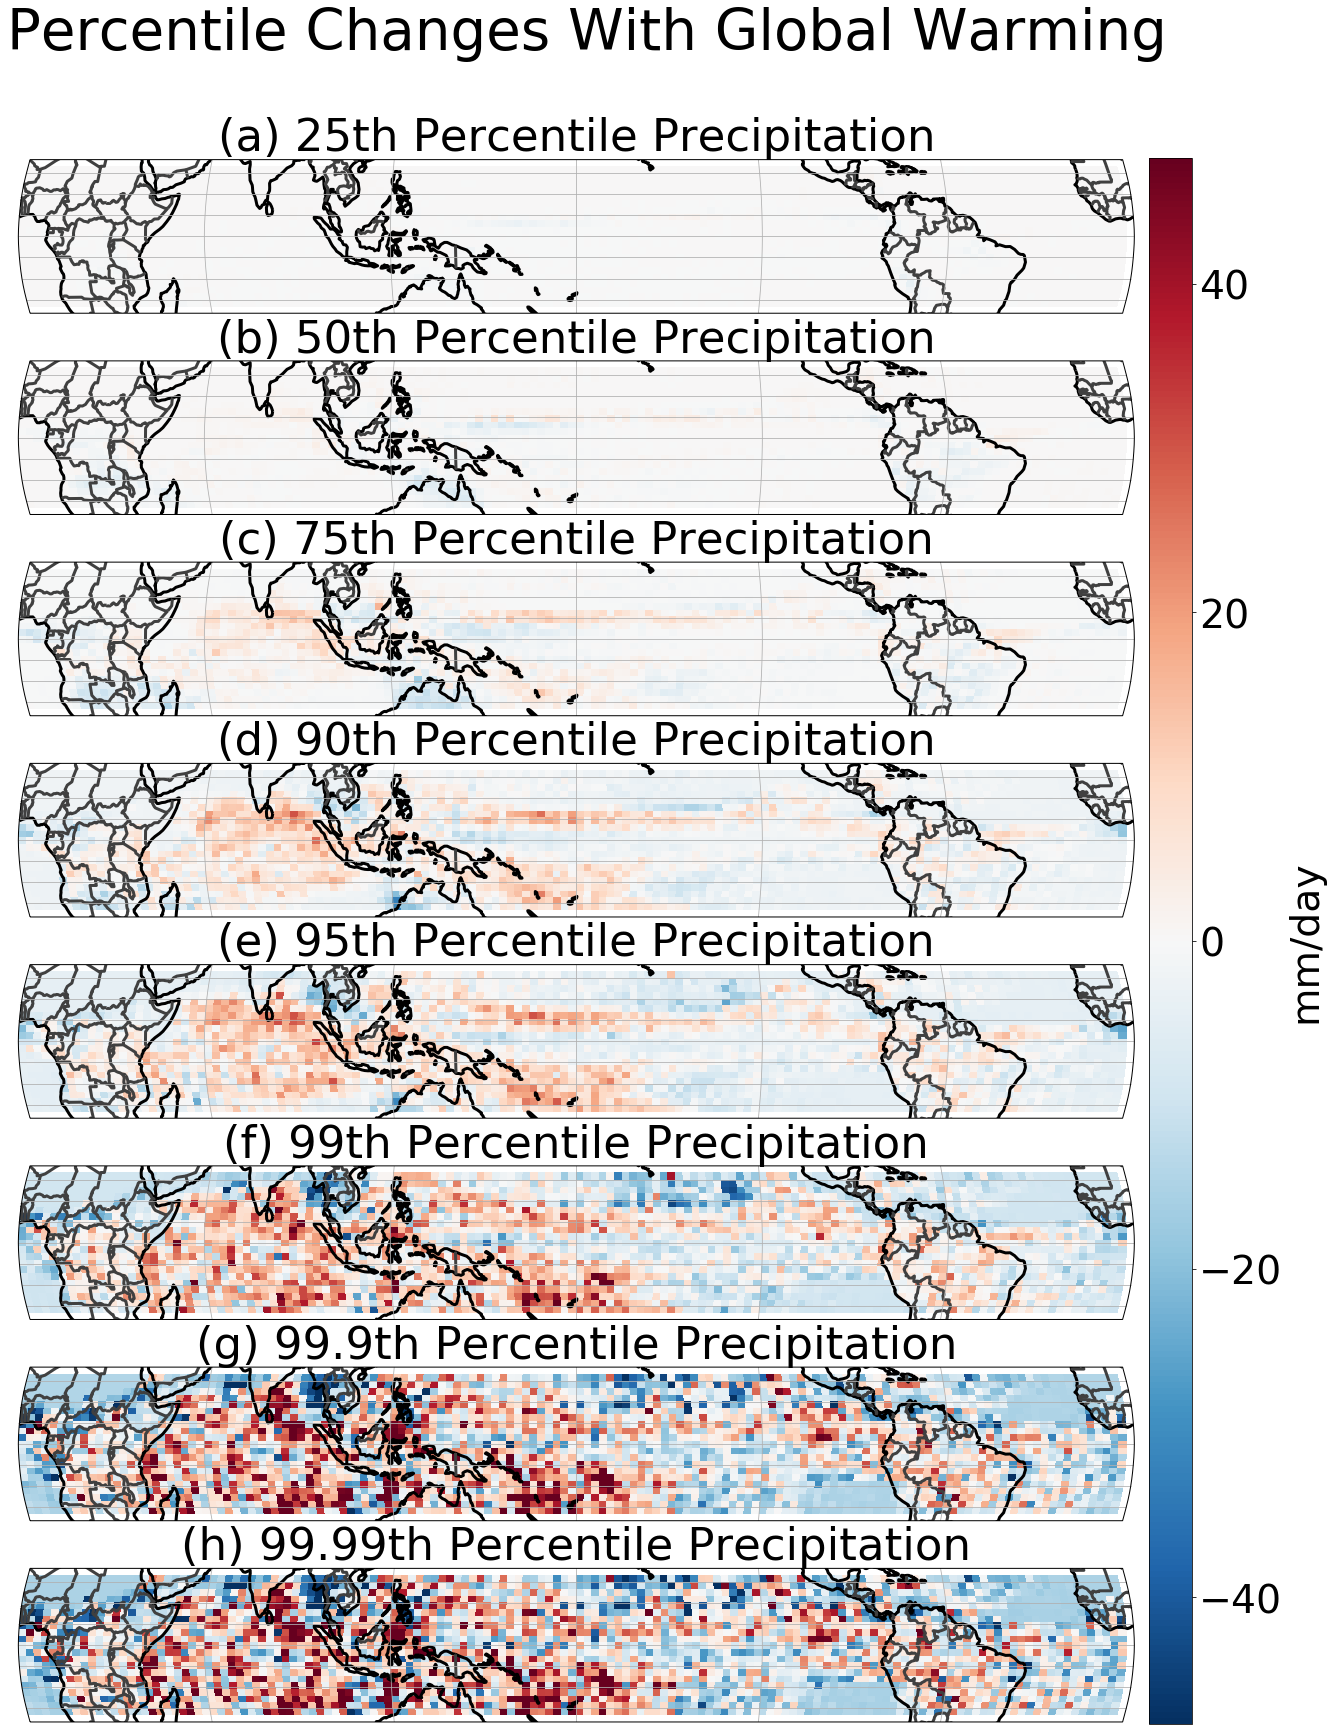

In [28]:
vmax = np.percentile(np.abs(P_99_4k - P_99_0k), 99)
vmin = -vmax

cmap = "RdBu_r"

fig, ax = plt.subplots(8,figsize=(20,29),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

contour_plot = ax[0].pcolormesh(new_lons, new_lats, P_25_4k - P_25_0k - np.mean(P_25_4k - P_25_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[0].coastlines(linewidth=3,edgecolor='0.25') 
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[0].set_title("(a) 25th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[1].pcolormesh(new_lons, new_lats, P_50_4k - P_50_0k - np.mean(P_50_4k - P_50_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[1].coastlines(linewidth=3,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[1].set_title("(b) 50th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[2].pcolormesh(new_lons, new_lats, P_75_4k - P_75_0k - np.mean(P_75_4k - P_75_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[2].coastlines(linewidth=3,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[2].set_title("(c) 75th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[3].pcolormesh(new_lons, new_lats, P_90_4k - P_90_0k - np.mean(P_90_4k - P_90_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[3].coastlines(linewidth=3,edgecolor='0.25')
ax[3].gridlines()
ax[3].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[3].set_title("(d) 90th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[4].pcolormesh(new_lons, new_lats, P_95_4k - P_95_0k - np.mean(P_95_4k - P_95_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[4].coastlines(linewidth=3,edgecolor='0.25')
ax[4].gridlines()
ax[4].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[4].set_title("(e) 95th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[5].pcolormesh(new_lons, new_lats, P_99_4k - P_99_0k - np.mean(P_99_4k - P_99_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[5].coastlines(linewidth=3,edgecolor='0.25') 
ax[5].gridlines()
ax[5].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[5].set_title("(f) 99th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[6].pcolormesh(new_lons, new_lats, P_999_4k - P_999_0k - np.mean(P_999_4k - P_999_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[6].coastlines(linewidth=3,edgecolor='0.25') 
ax[6].gridlines()
ax[6].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[6].set_title("(g) 99.9th Percentile Precipitation", fontsize = fz*2)

contour_plot = ax[7].pcolormesh(new_lons, new_lats, P_9999_4k - P_9999_0k - np.mean(P_9999_4k - P_9999_0k), cmap=cmap, transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax = vmax)
ax[7].coastlines(linewidth=3,edgecolor='0.25') 
ax[7].gridlines()
ax[7].add_feature(cfeature.BORDERS,linewidth=3,edgecolor='0.25')
ax[7].set_title("(h) 99.99th Percentile Precipitation", fontsize = fz*2)


cax_3 = fig.add_axes([0.91, 0.1275, 0.03, 0.75])
cb_3 = fig.colorbar(contour_plot, cax=cax_3)
cb_3.set_label('mm/day', fontsize=fz*1.75)
cb_3.ax.tick_params(labelsize=fz*1.75)

plt.suptitle("Percentile Changes With Global Warming", y = 0.95, x = 0.52, fontsize=fz*2.5)
plt.savefig("Figures/Figure_S3.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/Figure_S3.pdf", bbox_inches='tight',pad_inches = 0)